In [26]:
import pandas as pd
import json
import numpy as np
from nltk import sent_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
from tqdm import tqdm
from src import Helpers
import pickle
import spacy
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from random import choices

import matplotlib.pyplot as plt

# Preprocessing

## Step 1 : Load the datasets

### US movies dataset

In [27]:
CHARACTER_DATA_PATH = './data/character.metadata.tsv'
MOVIE_DATA_PATH = './data/movie.metadata.tsv'
SUMMARIES_DATA_PATH = './data/plot_summaries.txt'
NAME_DATA_PATH = './data/name.clusters.txt'
TYPE_DATA_PATH = './data/tvtropes.clusters.txt'

In [28]:
MOVIE_HEADER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date',
                'Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']

movies = pd.read_table(MOVIE_DATA_PATH,header=None,names=MOVIE_HEADER)

In [29]:
len(movies)

81741

In [30]:
def format_dict(x):
    n = len(x)
    if n==0:
        return np.nan
    else:
        return ','.join(str(s) for s in list(x.values()))
    

try :

    movies['Movie_genres'] = movies['Movie_genres'].apply(json.loads).apply(format_dict)
    movies['Movie_countries'] = movies['Movie_countries'].apply(json.loads).apply(format_dict)
    movies['Movie_languages'] = movies['Movie_languages'].apply(json.loads).apply(format_dict)
except json.decoder.JSONDecodeError:
    print('Data has already been parsed and modified.')
    
# Keep only American movies
us_movies = movies[movies['Movie_countries'].astype(str).str.contains('United States of America')]
print("Number of US movies : {}".format(len(us_movies)))

Number of US movies : 34408


In [33]:
us_movies.sample(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
53581,11339461,/m/02r8739,Pet Peeve,1954-11-20,NaN,NaN,English Language,United States of America,"Comedy,Children's/Family"
54038,36249048,/m/0k2kl8b,Detectives,1928-06-09,NaN,NaN,English Language,United States of America,"Mystery,Comedy film,Silent film"
36369,10021034,/m/02p_16r,Sometimes a Great Notion,1970-11-12,NaN,114.0,English Language,United States of America,"Romance Film,Drama"


### Summaries dataset

In [34]:
summaries = pd.read_table(SUMMARIES_DATA_PATH,header=None,names=['Wikipedia_movie_ID','Summary'])
summaries.dropna(inplace=True)
display(summaries)

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


### Character dataset

In [35]:
# Load character dataset
characters = Helpers.load_data("character.metadata.tsv")

# Change the names of certains columns
characters.rename(columns={'Wiki_movie_id': 'Wikipedia_movie_ID', 'Freebase character/actor map ID':'Fb_char_to_actor_ID'},
                  inplace=True)

# Drop rows where the name of the caracter played by the actor is unknown, or the name of the actor is unknown
characters.dropna(subset=['Character','Actor_name'],inplace=True,axis=0)

# Keep only characters related to US movies that have a synopsis
characters = characters[characters['Wikipedia_movie_ID'].isin(us_movies.Wikipedia_movie_ID.unique()) &
                        characters['Wikipedia_movie_ID'].isin(summaries.Wikipedia_movie_ID.unique())]

# Add name of the movie in which the character was present
tmp_dico = dict(zip(us_movies.Wikipedia_movie_ID, us_movies.Movie_name))
characters['Movie_name'] = characters.Wikipedia_movie_ID.apply(lambda x : tmp_dico[x])

# Important when using iterrows() (see later) : reset_index
characters.reset_index(drop=True, inplace=True)
characters.sample(3)

,Wikipedia_movie_ID,Fb_movie_id,release_date,Character,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_name,Actor_age,Fb_char_to_actor_ID,Fb_char_id,Fb_actor_id,Movie_name
51658,113442,0sxgv,1983.0,Jack Ridley,1940-05-26,M,NaN,NaN,Levon Helm,43.0,04_8_ky,0h3zl00,01vrx3g,The Right Stuff
57445,20137083,04yh4w4,1963.0,Speedy Gonzales,1908-05-30,M,NaN,041rx,Mel Blanc,54.0,0gb0gqb,0pxxk,0c5vh,A Message to Gracias
10267,612752,02wjwk,1977.0,Peewhittle,NaN,M,NaN,NaN,Christopher Tayback,NaN,0gc2vfz,0hp2_vq,0gc2vg1,Wizards


In [36]:
characters.shape

(93623, 14)

We have 93623 characters related to US movies for which we have a synopsis

Before moving further, let's check that 'Fb_char_to_actor_ID' is truly unique in this dataframe : we will use it as primary key later.

In [37]:
nb = (characters.Fb_char_to_actor_ID.value_counts() > 1).sum()
print(str(nb)+'\nOK !')

0
OK !


### CharType dataset (tvtropes)

In [38]:
# Load the 'tvtropes' dataset, thereafter called 'chartypes'
chartypes = Helpers.load_data("tvtropes.clusters.txt")
# Rename certains columns for coherence with other dataframes
chartypes.rename(columns={'Char':'Character', 'Movie':'Movie_name', 'Actor':'Actor_name', 'Fb_char_actor_id':'Fb_char_to_actor_ID'}, inplace=True)
display(chartypes)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,03lrjk0,Emilio Estevez


Unfortunately, we only have 501 characters which were given a character type (CharType) !

In [39]:
len(chartypes.CharType.unique())

72

Besides, we have 72 characters types : this is way too high, given the small amount of characterized characters we have. 

Let's reduce it. To do so, we asked ChatGPT to cluster our 72 CharTypes into only 7 main CharTypes, with a distribution between the MainCharTypes as even as possible. We obtained the following mapping : 

In [40]:
chartype_mapping = {
    'absent_minded_professor': 'Complex Personalities',
    'adventurer_archaeologist': 'Adventurers and Heroes',
    'arrogant_kungfu_guy': 'Complex Personalities',
    'big_man_on_campus': 'Stereotypes and Tropes',
    'bounty_hunter': 'Occupation and Professions',
    'brainless_beauty': 'Stereotypes and Tropes',
    'broken_bird': 'Moral Ambiguity and Antagonists',
    'bromantic_foil': 'Everyday Characters and Tropes',
    'bruiser_with_a_soft_center': 'Everyday Characters and Tropes',
    'bully': 'Stereotypes and Tropes',
    'byronic_hero': 'Complex Personalities',
    'casanova': 'Stereotypes and Tropes',
    'chanteuse': 'Complex Personalities',
    'charmer': 'Everyday Characters and Tropes',
    'child_prodigy': 'Adventurers and Heroes',
    'classy_cat_burglar': 'Stereotypes and Tropes',
    'consummate_professional': 'Adventurers and Heroes',
    'corrupt_corporate_executive': 'Moral Ambiguity and Antagonists',
    'coward': 'Moral Ambiguity and Antagonists',
    'crazy_jealous_guy': 'Emotional and Romantic Tropes',
    'crazy_survivalist': 'Complex Personalities',
    'cultured_badass': 'Adventurers and Heroes',
    'dean_bitterman': 'Everyday Characters and Tropes',
    'dirty_cop': 'Moral Ambiguity and Antagonists',
    'ditz': 'Stereotypes and Tropes',
    'doormat': 'Everyday Characters and Tropes',
    'drill_sargeant_nasty': 'Occupation and Professions',
    'dumb_blonde': 'Stereotypes and Tropes',
    'dumb_muscle': 'Stereotypes and Tropes',
    'eccentric_mentor': 'Complex Personalities',
    'egomaniac_hunter': 'Moral Ambiguity and Antagonists',
    'evil_prince': 'Moral Ambiguity and Antagonists',
    'fastest_gun_in_the_west': 'Adventurers and Heroes',
    'father_to_his_men': 'Occupation and Professions',
    'final_girl': 'Occupation and Professions',
    'gadgeteer_genius': 'Adventurers and Heroes',
    'gentleman_thief': 'Everyday Characters and Tropes',
    'granola_person': 'Complex Personalities',
    'grumpy_old_man': 'Everyday Characters and Tropes',
    'hardboiled_detective': 'Emotional and Romantic Tropes',
    'heartbroken_badass': 'Emotional and Romantic Tropes',
    'henpecked_husband': 'Everyday Characters and Tropes',
    'hitman_with_a_heart': 'Emotional and Romantic Tropes',
    'jerk_jock': 'Everyday Characters and Tropes',
    'junkie_prophet': 'Complex Personalities',
    'klutz': 'Everyday Characters and Tropes',
    'loser_protagonist': 'Everyday Characters and Tropes',
    'loveable_rogue': 'Everyday Characters and Tropes',
    'master_swordsman': 'Adventurers and Heroes',
    'morally_bankrupt_banker': 'Occupation and Professions',
    'officer_and_a_gentleman': 'Occupation and Professions',
    'ophelia': 'Emotional and Romantic Tropes',
    'playful_hacker': 'Occupation and Professions',
    'prima_donna': 'Emotional and Romantic Tropes',
    'psycho_for_hire': 'Moral Ambiguity and Antagonists',
    'pupil_turned_to_evil': 'Moral Ambiguity and Antagonists',
    'retired_outlaw': 'Occupation and Professions',
    'revenge': 'Emotional and Romantic Tropes',
    'romantic_runnerup': 'Emotional and Romantic Tropes',
    'self_made_man': 'Occupation and Professions',
    'slacker': 'Everyday Characters and Tropes',
    'stoner': 'Everyday Characters and Tropes',
    'storyteller': 'Complex Personalities',
    'stupid_crooks': 'Everyday Characters and Tropes',
    'surfer_dude': 'Occupation and Professions',
    'the_chief': 'Occupation and Professions',
    'the_editor': 'Occupation and Professions',
    'tranquil_fury': 'Emotional and Romantic Tropes',
    'trickster': 'Occupation and Professions',
    'valley_girl': 'Stereotypes and Tropes',
    'warrior_poet': 'Adventurers and Heroes',
    'young_gun': 'Occupation and Professions'
}

Now, we create a new column in `chartypes` called 'MainCharType', based on this mapping

In [41]:
chartypes['MainCharType'] = chartypes['CharType'].map(chartype_mapping)

chartypes.sample(3)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType
68,byronic_hero,Brand Hauser,War Inc.,02vczvr,John Cusack,Complex Personalities
341,loveable_rogue,Capt. Louis Renault,Casablanca,05286qg,Claude Rains,Everyday Characters and Tropes
444,stoner,Marty Mikalski,The Cabin in the Woods,083z84s,Fran Kranz,Everyday Characters and Tropes


Again, let's check for the unicity of 'Fb_char_to_actor_ID' in this dataframe...

In [42]:
chartypes.Fb_char_to_actor_ID.value_counts()

Fb_char_to_actor_ID
0k1xxm     5
02hw79s    4
0j_fvv     3
0j1__hv    3
0k65z5     3
          ..
0k79b3     1
0k60j5     1
0jx21w     1
0jy52w     1
0k39jj     1
Name: count, Length: 447, dtype: int64

**Unfortunately, it is not unique !**
As one can see above, some IDs correspond to multiple entries in the dataframe. Why ?

In [43]:
chartypes[chartypes.Fb_char_to_actor_ID == '0j1__hv']

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType
76,byronic_hero,Tony Stark,Iron Man,0j1__hv,Robert Downey Jr.,Complex Personalities
82,casanova,Tony Stark,Iron Man,0j1__hv,Robert Downey Jr.,Stereotypes and Tropes
263,gadgeteer_genius,Tony Stark,Iron Man,0j1__hv,Robert Downey Jr.,Adventurers and Heroes


Because some characters have been given multiple character types, called `CharType` ! 

To solve this, we keep only one entry, corresponding to the predominant `MainCharType`. Note that sometimes, multiples `CharType` could still have the same `MainCharType`

Besides, if two MainCharTypes have the same importance (i.e appear the same amount of times), then we use the following *priority list* to break the tie : the idea is to try to have an equal presence between the 7 MainCharTypes in the dataframe (this will be useful when performing kNN)

In [44]:
# The priority list to choose, if needed, between two 'MainCharType'
priority_list = chartypes.MainCharType.value_counts().sort_values().index.tolist()
priority_list

['Adventurers and Heroes',
 'Stereotypes and Tropes',
 'Complex Personalities',
 'Moral Ambiguity and Antagonists',
 'Emotional and Romantic Tropes',
 'Occupation and Professions',
 'Everyday Characters and Tropes']

In [45]:
# Get a list of the IDs that are problematic
nb = (chartypes.Fb_char_to_actor_ID.value_counts() > 1).sum()
conflicting_ids = (chartypes.Fb_char_to_actor_ID.value_counts() > 1).index[:nb]

In [46]:
def get_MainCharType(ID):
    
    """
    Input - ID : the 'Fb_char_to_actor_ID' of a character which has multiple entries in the 'chartypes' dataset
    Output - The most relevant MainCharType for this character
    """

    # Get the entries of the problematic ID, which was assigned at least two different CharType
    small_df = chartypes[chartypes.Fb_char_to_actor_ID == ID].copy()
    # Get the number of time each MainCharType appears for this character, sorted in decreasing order
    sorted_values = small_df.MainCharType.value_counts().tolist()
    sorted_types = small_df.MainCharType.value_counts().keys().tolist()
    # Special case : only one MainCharType
    if len(sorted_values) == 1:
        return(sorted_types[0])
    # Special case : if we detect a tie
    if sorted_values[0] == sorted_values[1]:
        # Get all the contenders of the tie (could be more than 2)
        contenders = sorted_types[:2]
        for i in range(2,len(sorted_values)):
            if sorted_values[i] == sorted_values[0]:
                contenders.append(sorted_types[i])
        # Break the tie using the priority list between MainCharTypes
        for e in priority_list:
            if e in contenders:
                return(e)
    # Default case : the MainCharType with the highest number of appearance wins
    return(sorted_types[0])  

In [47]:
# Get the MainCharType for each conflicting character
tmp_dico = {}
for ID in conflicting_ids:
    tmp_dico[ID] = get_MainCharType(ID)

# Drop duplicates in the dataframe
chartypes.drop_duplicates(subset=['Fb_char_to_actor_ID'],keep='first',inplace=True)

# Assign the proper MainCharType for each conflicting character in the dataframe
for ID in conflicting_ids:
    chartypes[chartypes.Fb_char_to_actor_ID == ID]['MainCharType'] = tmp_dico[ID]

C:\Users\beynes\AppData\Local\Temp\ipykernel_20348\2485288729.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chartypes[chartypes.Fb_char_to_actor_ID == ID]['MainCharType'] = tmp_dico[ID]


Has it work ?

In [48]:
(chartypes.Fb_char_to_actor_ID.value_counts() > 1).sum()

0

Yes !

In [50]:
display(chartypes)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType
0,absent_minded_professor,Professor Philip Brainard,Flubber,0jy9q0,Robin Williams,Complex Personalities
1,absent_minded_professor,Professor Keenbean,Richie Rich,02vchl3,Michael McShane,Complex Personalities
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,0k6fkc,Ian McKellen,Complex Personalities
3,absent_minded_professor,Dr. Harold Medford,Them!,0k6_br,Edmund Gwenn,Complex Personalities
4,absent_minded_professor,Daniel Jackson,Stargate,0k3rhh,James Spader,Complex Personalities
...,...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,0k776f,Bill Paxton,Occupation and Professions
497,young_gun,Colorado Ryan,Rio Bravo,0k2kqg,Ricky Nelson,Occupation and Professions
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,0k5nsh,Shane West,Occupation and Professions
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,03lrjk0,Emilio Estevez,Occupation and Professions


## Step 2 : merge `chartypes` and `characters`

Finally, we perform an outer join between `characters` and `chartypes` : when 'MainCharType' is unknown, it is filled with NaN. 

In [51]:
full_characters = chartypes.merge(characters, how='outer', on=['Fb_char_to_actor_ID','Character','Actor_name','Movie_name'])

In [52]:
full_characters.sample(3)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType,Wikipedia_movie_ID,Fb_movie_id,release_date,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_age,Fb_char_id,Fb_actor_id
67081,NaN,Samantha,The Way We Live Now,0n4l5hz,Samantha Jones,NaN,19259663.0,04lg8s6,1970.0,NaN,F,NaN,NaN,NaN,0n4l5j1,0gby8s3
7121,NaN,Janie Basdin,The American President,02vclk5,Samantha Mathis,NaN,258732.0,01m3wp,1995.0,1970-05-12,F,1.65,NaN,25.0,0h35hrr,05ry0p
54450,NaN,John Plummer,Stealing Harvard,04hv81k,Jason Lee,NaN,2037852.0,06gvhx,2002.0,1970-04-25,M,1.87,NaN,32.0,0h0tjnv,034np8


Does each character appear only once in this merged dataframe ? Yes ! 

In [53]:
(full_characters.Fb_char_to_actor_ID.value_counts() > 1).sum()

0

In [54]:
print("We have {} characters with unknown MainCharType".format(len(full_characters[full_characters.MainCharType.isnull()])))


We have 93201 characters with unknown MainCharType


In [55]:
print("And {} characters for which MainCharType is known".format(len(full_characters[full_characters.MainCharType.notna()])))


And 447 characters for which MainCharType is known


In [56]:
# Set 'Fb_char_to_actor_ID' as the new index for 'full_characters'
full_characters.index = full_characters.Fb_char_to_actor_ID

# Main analysis

Here comes the main question : 

**We have about 93k characters in `full_characters`, of which only about 450 have a MainCharType. How can we assign a MainCharType to those that do not have one ?**

By using NLP techniques...

But first, let's make sure that we do a movie synopsis for each entry of the `full_characters` dataset

In [57]:
# Number of entries before modification
before = len(full_characters)
# Keep only entries that have a synopsis in "summaries"
full_characters = full_characters[full_characters.Wikipedia_movie_ID.isin(summaries.Wikipedia_movie_ID.unique())]
# Number of entries after modification
after = len(full_characters)

print("By keeping only entries associated with a movie synopsis, we have lost {} entries".format(before-after))

By keeping only entries associated with a movie synopsis, we have lost 25 entries


In [58]:
print("And we have {} characters with known MainCharType and that are associated to a movie synopsis".format(
            len(full_characters[full_characters.MainCharType.notna()])))

And we have 422 characters with known MainCharType and that are associated to a movie synopsis


## Step 1 : Retrieve synopsis sentences related to each character in `full_characters`

For each entry/character in the dataframe, we want to get the sentences of the synopsis (of the movie in which the character appears) in which the character's name is mentionned.

To achieve the greatest possible retrieval rate, we must test multiple cases in each synopsis' sentence :
- Search for the entire character's name
- Search for the name of the actor who played the character
- Search for parts of the character's name (i.e. first name and last name)

In this last case, multiple subcases must be consider to avoir errors : 
- We don't want to search for linking workds and stopwords (ex : 'de' in 'Jack de Rose')
- We don't want to search for function nouns, since they are generic and could refer to another character (ex : 'Doctor','Captain','Lieutenant'...)

How to do this ? We establish a `dont_search_for` set that corresponds to the NLTK stopwords list.

Then we try to add words to this set that correspond to function nouns present in the dataset, by assuming that the function noun will always be placed first in a character's name. 

Besides, we restrict ourselves to character names of at least 3 words for two reasons. First, if the first word gets unwanted, we still have a word to search for in the synopsis. Second, the higher the number of words in a character name, the more likely the first word is to be a function noun.

On top of that, we delete all the words of the `dont_search_for` set that belongs to the dataset 'SSA_Names_DB', a CSV file of about 33k common first names that we downloaded from https://data.world/len/us-first-names-database. We want to keep searching for proper nouns, and especially for first names, since they are usually used in synopsis instead of the full character name ! 

In [59]:
# Load the dataset of common names and make it a set
common_names = set(pd.read_excel('SSA_Names_DB.xlsx')['Name'].unique())
common_names

{'Valdemar',
 'Jhenae',
 'Ameer',
 'Maddison',
 'Raelyn',
 'Juda',
 'Monserrat',
 'Danarius',
 'Evamarie',
 'Taysha',
 'Beau',
 'Bibiana',
 'Kyran',
 'Jewelia',
 'Haileigh',
 'Sephira',
 'Ciela',
 'Maicee',
 'Shahryar',
 'Romie',
 'Saydie',
 'Keiani',
 'Jezabelle',
 'Kavir',
 'Harlei',
 'Kaladin',
 'Kiva',
 'Heloise',
 'Janissa',
 'Bellamie',
 'Eliahs',
 'Avenlee',
 'Owin',
 'Shivang',
 'Kvon',
 'Rashiya',
 'Gibson',
 'Casyn',
 'Modesireoluwa',
 'Amoy',
 'Malissa',
 'Nkosi',
 'Alana',
 'Tarrance',
 'Manit',
 'Awesome',
 'Zakya',
 'Xaniya',
 'Luc',
 'Jeremie',
 'Deslynn',
 'Meziah',
 'Jacobie',
 'Demi',
 'Lettie',
 'Aniston',
 'Amalia',
 'Gwenneth',
 'Tarrell',
 'Cayne',
 'Nariah',
 'Karra',
 'Naihomy',
 'Brea',
 'Tahir',
 'Parneet',
 'Henrietta',
 'Elzie',
 'Asiyah',
 'Marek',
 'Griselda',
 'Marena',
 'Elvina',
 'Jakira',
 'Skylyn',
 'Osama',
 'Amirrah',
 'Heli',
 'Layten',
 'Blayke',
 'Malyah',
 'Mattis',
 'Anaylah',
 'Corynn',
 'Zanya',
 'Euphemia',
 'Eibhlin',
 'Roisin',
 'Alesha',


In [60]:
# Create the set of words we should not search for, complete it with NLTK stopwords list
dont_search_for = set(list(stopwords.words('english')))
# We can already add some words
dont_search_for.update(['de','Captain'])

for _, entry in full_characters.iterrows():
    # Split the character's name into multiple strings, using ' ' as a separator
    split_name = entry['Character'].split()
    # Get the first word
    potential_noun = split_name[0]
    # If it a string of the form " Alicia's ", we want to remove " 's " at the end in order to detect that it is a name
    test_name = potential_noun.removesuffix("'s")
    # But it could be not a name : "client's" becomes "client", and "client" is not a name. 
    # So we test if it belongs to common_names
    if len(split_name) >= 3 and test_name not in common_names:
        # Add the original word if not already present
        if potential_noun not in dont_search_for:
            dont_search_for.add(potential_noun)

In [61]:
sorted(dont_search_for)

["'2-Gun'",
 "'A'",
 "'Ayatollah",
 "'Baby",
 "'Badge",
 "'Bluebeard',-",
 "'Buttons'",
 "'Captain'",
 "'Cousin'",
 "'Damian',",
 "'Dearest'",
 "'Dice-man'",
 "'Fat'",
 "'Helix'",
 "'Horny'",
 "'Hot",
 "'Joliet'",
 "'Jose'",
 "'Juicy'",
 "'Jumpin'",
 "'Kit",
 "'Klownzilla'",
 "'Little",
 "'Little'",
 "'MILF'",
 "'Michael",
 "'Nuff",
 "'Og'",
 "'Reverend'",
 "'Ronald",
 "'Smilin'",
 "'The",
 "'Time",
 "'Tip'",
 "'Too",
 "'Uncle",
 "'Uncle'",
 "'Wacky'",
 "'Wild",
 "'Wild'",
 '....',
 '01',
 '16',
 '17',
 '1931',
 '1978',
 '1st',
 '2nd',
 '3rd',
 '4th',
 '5',
 '5th',
 '6',
 '7-Year-Old',
 '9',
 'A',
 'A.',
 'A.C.,',
 'A.J.',
 'A.R.',
 'A.T.F.',
 'ACWO',
 'ADA',
 'Aardvark',
 'Above',
 'Academy',
 'Ace,',
 'Acme',
 'Actor',
 'Actress',
 'Actress/Breast',
 'Additional',
 'Adm.',
 'Admiral',
 'Admissions',
 'Adult',
 'Advisor',
 'Afghan',
 'Agathon',
 'Aged',
 'Agent',
 'Aging',
 'Ah',
 'Air',
 'Airbag',
 'Airman',
 'Airplane',
 'Airport',
 'Al,',
 'Alaskan',
 'Albus',
 'Alfred,',
 'Ali-Mod

In [62]:
len(dont_search_for)

2091

In [63]:
# Save the set
with open('dont_search_for.pkl', 'wb') as f:
    pickle.dump(dont_search_for, f)

The result is not perfect, but we still have managed to detect many nouns and stopwords in characters' names

Now, we use this to assign to each character of `full_characters` the sentences of the movie synopsis where it is mentionned.

In [65]:
total_related_sent = []
total_related_sent_indices = []

for _, entry in tqdm(full_characters.iterrows(), total=full_characters.shape[0]):
    related_sent = []
    related_sent_indices = []
    # Get character name
    name = entry['Character']
    # Split it into substrings
    split_name = name.split()
    # Get related synopsis
    synopsis = summaries.loc[summaries.Wikipedia_movie_ID == entry.Wikipedia_movie_ID, 'Summary'].values[0]
    # Clean and split the synopsis into sentences
    synopsis = synopsis.replace(u'\xa0', u' ')
    synopsis = synopsis.replace(u'\xc2','')
    sentences = sent_tokenize(synopsis)
    # Search for sentences containing the name of the character
    for i in range(len(sentences)):
        sentence = sentences[i]
        # First, we search for the full characer's name or actor's name
        if name in sentence or entry['Actor_name'] in sentence:
            related_sent.append(sentence)
            related_sent_indices.append(i)
        # If this has not worked, we search for words in the character's name, while being cautious ('dont_search_for' set)
        else:
            for word in split_name:
                if len(word) > 1 and word in sentence and word not in dont_search_for:
                    # Check before that we don't add a duplicate
                    if i not in related_sent_indices:
                        related_sent.append(sentence)
                        related_sent_indices.append(i)
    # Save the results 
    if len(related_sent) != 0:
        total_related_sent.append(related_sent)
        total_related_sent_indices.append(related_sent_indices)
    else:
        total_related_sent.append(np.nan)
        total_related_sent_indices.append(np.nan)

        
full_characters['related_sent'] = total_related_sent
full_characters['related_sent_indices'] = total_related_sent_indices
full_characters.sample(3)

100%|██████████████████████████████████████████████████████████████████████████| 93623/93623 [01:22<00:00, 1129.63it/s]


,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType,Wikipedia_movie_ID,Fb_movie_id,release_date,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_age,Fb_char_id,Fb_actor_id,related_sent,related_sent_indices
Fb_char_to_actor_ID,,,,,,,,,,,,,,,,,,
0gdkqk_,NaN,Ricky,The Steam Experiment,0gdkqk_,Shelby Stehlin,NaN,19522919.0,04mx30t,2009.0,NaN,M,NaN,NaN,NaN,0n5d0mg,0gdkql3,NaN,NaN
0jxzt0,NaN,David Grant,Executive Decision,0jxzt0,Kurt Russell,NaN,67422.0,0hqrx,1996.0,1951-03-17,M,1.78,NaN,44.0,0gz5ky4,01g969,"[Dr. David Grant , a United States Naval Acade...","[2, 5, 7, 11, 13, 19, 25, 29, 31, 32, 33, 39, ..."
0h3c2pl,NaN,Dax,National Lampoon's Pledge This!,0h3c2pl,Geoffrey Arend,NaN,2310118.0,072txz,2006.0,1978-02-28,M,1.90,NaN,28.0,0h3c2pp,06zs0s1,NaN,NaN


In [66]:
full_characters.shape

(93623, 18)

In [67]:
percentage = len(full_characters[full_characters.related_sent_indices.notna()]) / len(full_characters)
print("Percentage of characters in the dataframe that could be associated with synopsis sentences : {:2.2%}".format(percentage))

Percentage of characters in the dataframe that could be associated with synopsis sentences : 51.91%


That's quite satisfying : we should be able to classify the MainCharType for more than half the characters of the database !

In [68]:
# We keep only entries for which related synopsis sentences could be retrieved
full_characters.dropna(subset=['related_sent'],inplace=True)

Let's check the median number of sentences for each entry (i.e. character) in the dataframe :

In [69]:
median = full_characters.related_sent_indices.apply(lambda x : len(x)).median()
print("Median of the number of sentences per character : {:.2}".format(median))

Median of the number of sentences per character : 4.0


It seems large enough to have a good characterization of most characters !

## Step 2 : complete `full_characters` with embeddings of corresponding sentences

In another script, we have calculated embeddings for every sentence of every synopsis, by using sentence transformer model ('all-MiniLM-L6-v2', based on BERT model). See annex script. Let's load it :

In [70]:
# Load the embeddings of the sentences of every synopsis
with open('all_embeddings.pickle', 'rb') as handle:
    all_embeddings = pickle.load(handle)

**all_embeddings** is a dictionnary : each key is a **Wikipedia_movie_ID**, and contains the following tuple : 

**(mean_vector, all_vectors)** = (mean of all sentence embeddings, list of the embeddings of all the sentences in the synopsis)

Now, we add to each entry of `full_characters` the embeddings corresponding to the sentences related to this entry/character

In [71]:
total_related_embeddings = []

# For each entry/character of the dataframe
for _, entry in tqdm(full_characters.iterrows(), total=full_characters.shape[0]):
    related_embeddings = []
    # Get all the embeddings for the synopsis of the movie in which the character appears
    embeddings_of_synopsis = all_embeddings[entry.Wikipedia_movie_ID][1]
    # Keep only the embeddings of sentences that mention the character
    for index in entry.related_sent_indices:
        related_embeddings.append(embeddings_of_synopsis[index])
    # Store the result
    total_related_embeddings.append(related_embeddings)

full_characters['related_embeddings'] = total_related_embeddings

100%|█████████████████████████████████████████████████████████████████████████| 48598/48598 [00:03<00:00, 15570.95it/s]


For instance, for Captain Jack Sparrow in *Pirates of the Caribbean: Dead Man's Chest* (ID "0k1xxm"), we get the following related sentences, and their corresponding embeddings :

In [72]:
full_characters[full_characters.Fb_char_to_actor_ID == '0k1xxm']['related_sent'].values

array([list([' On their wedding day Will Turner and Elizabeth Swann are confronted by Lord Cutler Beckett, head of the East India Trading Company, with arrest warrants for their helping pirate Captain Jack Sparrow escape execution.', 'Former Commodore Norrington is also wanted for delaying the pursuit of Sparrow, but Norrington has resigned from the British Royal Navy months prior and disappeared.', "Beckett sends Will to recover Jack's compass in exchange for letters of marque that will make Sparrow a British privateer, and he promises Will and Elizabeth pardons.", "Will's father Bootstrap Bill Turner tells Jack he must keep his own promise to join the crew of Davy Jones, who raised the sunken Black Pearl for him years ago.", 'When Jack refuses, Bootstrap tells him Davy\'s "pet" will drag him to Davy Jones\' Locker.', 'Will finds the Black Pearl at Pelegosto, where a cannibal tribe worships Jack as a god, planning to kill him to release him from his "human state".', "After a jungle ch

Here's what the embedding of the first sentence looks like

In [74]:
full_characters[full_characters.Fb_char_to_actor_ID == '0k1xxm']['related_embeddings'].values[0][0]

array([-1.02143340e-01,  1.26641025e-04,  5.92070399e-03, -2.70770881e-02,
        2.81091481e-02,  4.94809784e-02,  6.44272342e-02, -8.73776749e-02,
        5.36105596e-02, -1.32116033e-02, -8.34304467e-02,  6.49585500e-02,
       -4.55500819e-02,  6.49644062e-03, -4.16487306e-02,  3.83720472e-02,
       -2.44273134e-02, -2.50329394e-02,  3.02963443e-02,  1.39223441e-01,
       -3.13934870e-02, -1.66718587e-02, -1.81097332e-02,  2.92597767e-02,
       -8.89931470e-02, -8.92117769e-02,  5.13707399e-02, -8.07738164e-04,
       -4.18717824e-02, -5.50634135e-03,  6.83386549e-02,  2.56668720e-02,
        1.63973775e-03,  1.01123244e-01, -6.20653667e-02, -2.59437189e-02,
        6.03881218e-02,  2.51825079e-02,  2.00404897e-02, -6.76899701e-02,
        1.26722939e-02,  3.44249867e-02,  3.45343165e-02,  4.25143465e-02,
        4.47375700e-02, -5.25767580e-02, -1.65469013e-02,  2.18846370e-02,
       -3.05079389e-03,  2.98175942e-02, -3.25046144e-02, -2.96176001e-02,
       -5.99275306e-02, -

Let's save our results

In [75]:
full_characters.to_pickle('full_characters_step1') 

## Step 3 : differentiate between active and passive subjects in characters related sentences

In [76]:
# Load the dataframe prepared in previous steps
full_characters = pd.read_pickle('full_characters_step1')

In [77]:
# We also load the 'dont_search_for' list made in the previous steps
with open('dont_search_for.pkl', 'rb') as f:
    dont_search_for = pickle.load(f)

Before trying to classify our unlabeled characters between the 7 MainCharTypes, we must consider one additional piece of information. Indeed, when using the embedding of a sentence, we somehow lose track of which characters do what in the action described by the sentence.

For instance, in a sentence like "Alice tortures Bob", the embedding would translate the fact that someone tortures someone else. But who ?

If we are trying to assign a MainCharType to Bob, it matters to know that Bob is the one that gets tortured (could mean that he is a tragic figure for instance) and not the torturer (could mean that he is a villain).

Therefore, for each related sentence to each character, we must say is the character at hand is active or passive. This idea to differentiate between actions performed or underwent by the character was already present in the paper related to the database (*Learning Latent Personas of Film Characters*, Bammam et al.).

To do so, we use the dependency tags of Spacy (note : we only need its tokenizer, tagger and parser components)

In [78]:
nlp = spacy.load('en_core_web_sm', disable=['attribute_ruler', 'lemmatizer','ner'])

The list of dependency tags is listed here : https://universaldependencies.org/docs/en/dep/

Another well-explained list is found here : https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md

Now, we define a function that, given a sentence and a character name (which should appear in the sentence), tells if the character is passive (undergo the action) or active (create the action) in the sentence. If the sentence contains multiple propositions with multiple mentions of the character, it will only focus on the first proposition in which the character appears.

In [81]:
def is_active(sentence, character_name):
    
    """
    Input - 
    "sentence" : a sentence as a string
    "character_name" : the name of a character, as a string, that is expected to appear inside the sentence
    Output -
    boolean : True if the character is active in the action described by the sentence, False otherwise
    """
    
    # Split the character's name into substrings
    tmp_split_name = character_name.split()
    split_name = [w for w in tmp_split_name if w not in dont_search_for]
    # Gather all the words related to the character's name in a list, except words in dont_search_for
    if len(split_name) > 1:
        char_words = [character_name] + split_name
    else:
        char_words = [character_name]
    # Get a Spacy object from raw sentence
    doc = nlp(sentence)
    
    for index,token in enumerate(doc):
        token_text = token.text
        
        # Test if token related to the character
        for word in char_words:
            if len(word) > 1 and word in token_text:
                                
                # Test if the token is active nominal subject 
                if token.dep_ == 'nsubj':
                    return True
                
                # Test if the token is passive nominal subject or direct object
                if token.dep_ == 'nsubjpass' or token.dep_ == 'dobj':
                    return False
                
                # Test if the token is object of preposition (POBJ) or possession modifier or conjunct or object predicate or noun
                if token.dep_ == 'pobj' or token.dep_ == 'poss' or token.dep_ == 'conj' or token.dep_ == 'oprd' or 'NN' in token.tag_ :
                    # If True, try to find the word to which it is directly related (assumed to be near it in the sentence)
                    # Get increasingly further from the POBJ and stop when a verb or marker is encountered
                    # (since it is unlikely to have the related word to our token beyond a verb or marker)
                    
                    # Inspect words before
                    j = index
                    while j >= 1 and ((not doc[j-1].tag_.startswith('VB')) or doc[j-1].dep_ == 'acl' or doc[j-1].tag_ == 'VBG') and doc[j-1].dep_ != 'mark':
                        j -= 1
                        # Test if the word is an active nominal subject (assumed to be related to the main token) or a gerund or an agent
                        if doc[j].dep_ == 'nsubj' or doc[j].tag_ == 'VBG' or doc[j].dep_ == 'agent':
                            return True
                        # Test if the word is a passive nominal subject (assumed to be related to the main token)
                        if doc[j].dep_ == 'nsubjpass':
                            return False
                        
                    # Inspect words after
                    j = index
                    while j < len(doc)-1 and ((not doc[j+1].tag_.startswith('VB')) or doc[j+1].dep_ == 'acl' or doc[j+1].tag_ == 'VBG') and doc[j+1].dep_ != 'mark':
                        j += 1
                        # Test if the word is an active nominal subject (assumed to be related to the main token) or a gerund
                        if doc[j].dep_ == 'nsubj' or doc[j].tag_ == 'VBG' or doc[j].dep_ == 'agent':
                            return True
                        # Test if the word is a passive nominal subject (assumed to be related to the main token)
                        if doc[j].dep_ == 'nsubjpass':
                            return False
                        
    # Ultimate test : given all the tests performed so far, if the subject of the sentence is active
    # then it is likely that the character is passive
    if 'nsubj' in [t.dep_ for t in doc]:
        return False
    # Eventually, return default value : character is assumed to be active  
    return True

In [82]:
# Let's make a test : True = Active, False = Passive
sentence = "Sparrow's hand was cut by the sword of a dangerous captain"
character_name = 'Captain Jack Sparrow'
is_active(sentence, character_name)

False

In [83]:
# We use this function on all our sentences

results_total = []

# For each character in the dataframe
for character_ID in tqdm(full_characters.index):
    character_name = full_characters.loc[character_ID, 'Character']
    results = []
    # For each related sentence, test if the character is active or passive 
    for sentence in full_characters.loc[character_ID, 'related_sent']:
        results.append(is_active(sentence, character_name))
    results_total.append(results)
    
# Store the results 
full_characters['is_active'] = results_total

100%|████████████████████████████████████████████████████████████████████████████| 48598/48598 [17:49<00:00, 45.44it/s]


In [84]:
full_characters.to_pickle('full_characters_step2') 

In [77]:
test = full_characters.explode(['related_sent','related_sent_indices','related_embeddings','is_active'])
test.sample(10)[['Character','is_active','related_sent']].values

array([['Mugsy', False,
        'Rocky responds: "This guy knows too much, Mugsy.'],
       ['Jackson Curtis', True,
        'Jackson and Noah dislodge the impact driver and the crew regains control of the ark before it collides with Mount Everest.'],
       ['Maria Tura', True,
        'Asked what reward he\'d like for his service to the Allies, Tura hems and haws in a show of false modesty, but Maria quickly answers in his stead, "he wants to play Hamlet."'],
       ['Penelope Elcott', True,
        "Ducky and Sabada pay a visit to Penelope's home, telling her they have proof that she robbed the bank, and blackmail her."],
       ['Ione', False,
        'Afterwards, at a "costume party" hosted at Sander\'s house, where only Sander and Riley dress up , Riley gets very drunk after seeing Clapton kissing Ione and begins to make out with Sander in an attempt to make Clapton jealous.'],
       ['Nick Curran', True,
        'At this, Catherine stops reaching for something under the bed, an

Again, some errors appear, but the result is overall satisfying for our purposes.

## Step 4 : design an ad-hoc kNN-based model and validate it with Leave-one-out cross-validation

In [86]:
# Load the dataframe built before
full_characters = pd.read_pickle('full_characters_step2')

In [87]:
# We split our dataframe in two parts : one with known MainCharTypes, one with unkown MainCharType
labeled = full_characters[full_characters.MainCharType.notna()].copy()
unlabeled = full_characters[full_characters.MainCharType.isnull()].copy()

Let's look at the number of labeled sentences (i.e. related to a labeled character) that we have for each trope :

In [90]:
nb_sent_per_type = labeled.groupby(['MainCharType']).related_sent_indices.sum().apply(len)
nb_sent_per_type

MainCharType
Adventurers and Heroes              586
Complex Personalities               816
Emotional and Romantic Tropes      1033
Everyday Characters and Tropes     1039
Moral Ambiguity and Antagonists     701
Occupation and Professions          784
Stereotypes and Tropes              619
Name: related_sent_indices, dtype: int64

We observe that the distribution of labeled characters between the 7 MainCharTypes is not completely uniform : our classes are imbalanced.

Let's use the number of sentences per MainCharType to calculate weightings. This will help our model account for imbalances between classes.

In [91]:
weights = {}
char_types = ['Adventurers and Heroes','Complex Personalities','Emotional and Romantic Tropes',
              'Everyday Characters and Tropes','Moral Ambiguity and Antagonists','Occupation and Professions',
              'Stereotypes and Tropes']

# Weight for each MainCharType is the inverse of the number of sentences related to it
for t in char_types:
    weights[t] = 1 / nb_sent_per_type[t]

# Normalize the weights
total = sum(weights.values())
for t in char_types:
    weights[t] = weights[t] / total

weights

{'Adventurers and Heroes': 0.18589065040699315,
 'Complex Personalities': 0.13349500139521814,
 'Emotional and Romantic Tropes': 0.10545200497434462,
 'Everyday Characters and Tropes': 0.10484304248171127,
 'Moral Ambiguity and Antagonists': 0.15539503728744364,
 'Occupation and Professions': 0.13894377696236987,
 'Stereotypes and Tropes': 0.17598048649191922}

We will now used a **kNN-based model to predict the MainCharType of every unlabeled character**. The algorithm is the following. 

We initialize a score to zero for each of the 7 MainCharTypes. Then, for the character to predict :
- For a sentence S related to the character, determine if the character is active or passive in it. Choose the set of labeled sentences LABELED accordingly
- Calculate the cosine similarity between S and each sentence (embedding) in LABELED
- Find the k sentences in LABELED which have the highest cossim with S. Each of them  is related to a MainCharType. Add to this latter's score the cossim found, multiplied by the weight (see below) for this MainCharType
- Repeat for each sentence related to the character
- Return the MainCharType with highest score. Also return a probability distribution of the character's MainCharType over the 7 catagories, based on the scores obtained

Many versions of this model could be tried (value for k ? use weightings, and if yes, which formula to compute them ? use the distinction between active and passive sentences ? give a boost to the first sentence related to the character, which often introduces it ?).

To choose the better version of our model, we performed **Leave-one-out cross validation** : for each character with known MainCharType, we try to predict his MainCharType with our model using all the other labeled entries. Then we compute a quality score to assess the performance. Here, the quality score retained was the **mean value between intra-class accuracies** : for each MainCharType, we compute the accuracy obtained, then we compute the mean between all these values (compensate for imbalanced classes).

Eventually, after dozens of tries, we have kept our model simple : **k = 2 and we use weightings** as calculated above.

Our model is described in the function below :

In [94]:
def predict_type_cross_validation(unlabeled, labeled):
    
    """
    Input -
    unlabeled : dataframe with all sentences related to unlabeled character A (character's row from 'full_characters')
    labeled : dataframe with all sentences related to all labeled characters (one row per sentence) 
                ==> Explode dataframe before passing
    Output -
    mainchartype : prediction on the MainCharType of character A.  
    
    Note : Model based on kNN : we keep the 5 closest neighboors + With weightings + With boost
    """
    
    votes_on_type = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    
    nb_neighb = 2 # hyperparameter "k" in kNN
    
    # Split labeled dataframe between "active" and "passive" sentences
    labeled_active = labeled[labeled.is_active == True].reset_index(drop=True)
    labeled_passive = labeled[labeled.is_active == False].reset_index(drop=True)
    
    # For each sentence related to the unlabeled character
    for index_sent, unlabeled_sent in enumerate(unlabeled['related_embeddings']):
        
        # Initialize two max values and corresponding MainCharTypes
        max_val = [-9-i for i in range(nb_neighb)] # We keep this decreasing order between the two highest values at each instant
        max_type = [None for _ in range(len(max_val))]
        
        # If character is active in sentence, use the set of active sentences to perform kNN
        if unlabeled.is_active[index_sent] == True:
            labeled_to_use = labeled_active
        # Use set of passive sentences otherwise
        else:
            labeled_to_use = labeled_passive
            
        # For each labeled sentence
        for k in range(len(labeled_to_use)): 
    
            labeled_sent = labeled_to_use.at[k, 'related_embeddings']
        
            # Calculate cosine similarity
            val = np.dot(unlabeled_sent,labeled_sent)/(np.linalg.norm(unlabeled_sent)*np.linalg.norm(labeled_sent))
            
            if val > max_val[0]:
                # val is greater than all two highest values
                max_val[0] = val
                max_type[0] = labeled_to_use.at[k, 'MainCharType']
            elif val > max_val[1]:
                # val is smaller than max_val[0] but greater than max_val[1]
                max_val[1] = val
                max_type[1] = labeled_to_use.at[k, 'MainCharType']
                
        votes_on_type[max_type[0]] += weights[max_type[0]] * max_val[0]
        votes_on_type[max_type[1]] += weights[max_type[1]] * max_val[1]
        
    # Get the MainCharType with highest value
    mainchartype = max(votes_on_type, key=votes_on_type.get)
    
    # Build some sort of probability distribution for the MainCharType (normalization of votes_on_type)
    total = sum(votes_on_type.values())
    probabilities = {key: value / total for key, value in votes_on_type.items()}
    
    return(mainchartype, probabilities)

We perform here the LOO cross-validation that led to the best performance. Note that the accuracy computed here (number of correct predictions divided by number of predictions) is not the performance score that we used to compare between different versions of the model.

In [95]:
correct_predictions = 0

# To understand the distribution of errors, we will compute a confusion matrix
cross_tab = pd.DataFrame(index=char_types, columns=char_types).fillna(0)

for char_ID in tqdm(labeled.index):
    tmp_labeled = labeled.drop(index=char_ID).explode(['related_sent','related_embeddings','related_sent_indices','is_active'])
    (prediction,probabilities) = predict_type_cross_validation(labeled.loc[char_ID], tmp_labeled)
    correct_predictions += int(prediction == labeled.loc[char_ID]['MainCharType'])
    cross_tab.at[labeled.loc[char_ID]['MainCharType'], prediction] += 1
    
print("Accuracy of the model is {:2.2%}".format(correct_predictions / len(labeled)))

100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:11<00:00,  2.19it/s]

Accuracy of the model is 32.70%


We can compute the confusion matrix, based on exact predictions : 

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.7222222222222, 0.5, 'True')]

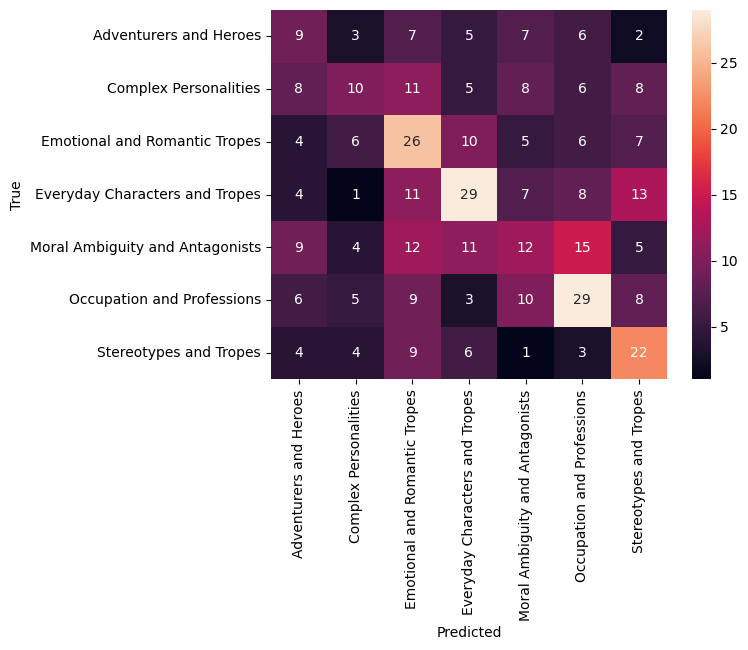

In [101]:
ax = sns.heatmap(cross_tab, annot=True)
ax.set(xlabel="Predicted", ylabel="True")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.7222222222222, 0.5, 'True')]

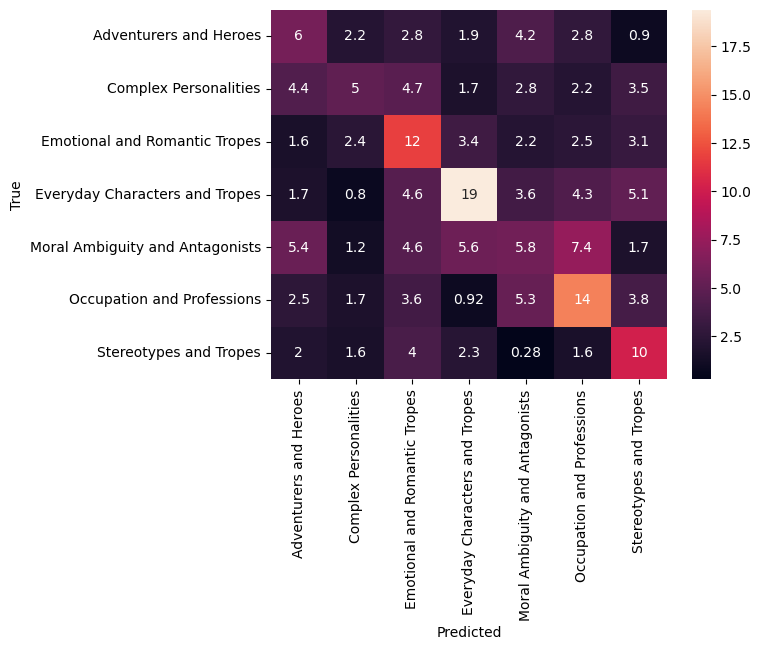

In [105]:
ax = sns.heatmap(cross_tab_proba, annot=True)
ax.set(xlabel="Predicted", ylabel="True")

In [103]:
accuracy_per_class = []

for i in range(len(cross_tab)):
    percentage = cross_tab.iat[i,i] / cross_tab.iloc[i].sum()
    accuracy_per_class.append(percentage)
    print("Accuracy for {} : {:2.2%}".format(cross_tab.index[i], percentage))
    
print("Mean accuracy over all class : {:2.2%}".format(sum(accuracy_per_class)/len(accuracy_per_class)))

Accuracy for Adventurers and Heroes : 23.08%
Accuracy for Complex Personalities : 17.86%
Accuracy for Emotional and Romantic Tropes : 40.62%
Accuracy for Everyday Characters and Tropes : 39.73%
Accuracy for Moral Ambiguity and Antagonists : 17.65%
Accuracy for Occupation and Professions : 41.43%
Accuracy for Stereotypes and Tropes : 44.90%
Mean accuracy over all class : 32.18%


Our mean accuracy over all class is 32.18 %, which is not an exceptionnal performance.

However, given the simplicity of our model, our lack of knowledge in NLP and the difficulty of the task (even an human would find it difficult for some characters to assign only one MainCharType : characters are often complex and multi-dimensionnals), it is not that bad.

Besides, what would be the accuracy of a stupid predictor, where we predict for any character input the same MainCharType output, corresponding to the dominant class in the samples ? Let's compare the number of labeled characters between MainCharTypes :

In [108]:
nb_sent_per_type = labeled.groupby(['MainCharType']).apply(len)
nb_sent_per_type

MainCharType
Adventurers and Heroes             39
Complex Personalities              56
Emotional and Romantic Tropes      64
Everyday Characters and Tropes     73
Moral Ambiguity and Antagonists    68
Occupation and Professions         70
Stereotypes and Tropes             49
dtype: int64

With this stupid predictor, accuracy per class would be 0% for each class, except for "Everyday Characters and Tropes" (dominant class here, in terms of labeled characters) where it would be 73 / 419 ~ 17 %. Then, taking the average over all accuracy per class would give 0.17 / 7 = 2.5 % !

In comparison, our classifier performs way better ! We will stick to it for the rest of the project.

## Step 5 : Test

Let's make a function based on the same model, but designed for prediction on unlabeled data (no more cross validation).

In [113]:
def predict_type(unlabeled, labeled_active, labeled_passive):
    
    """
    Input -
    unlabeled : dataframe with all sentences related to unlabeled character A (character's row from 'full_characters')
    labeled_active : dataframe with all active sentences related to all labeled characters (one row per sentence) 
                ==> Explode dataframe before passing
    labeled_passive : dataframe with all passive sentences related to all labeled characters (one row per sentence) 
                ==> Explode dataframe before passing
    Output -
    mainchartype : prediction on the MainCharType of character A.  
    
    Note : Model based on kNN : we keep the 2 closest neighboors + With weightings
    """
    
    votes_on_type = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    
    nb_neighb = 2
    
    # For each sentence related to the unlabeled character
    for index_sent, unlabeled_sent in enumerate(unlabeled['related_embeddings']):
        
        # Initialize 2 max values and corresponding MainCharTypes
        max_val = [-1-i for i in range(nb_neighb)] # We keep this decreasing order between the two highest values at each instant
        max_type = [None for _ in range(len(max_val))]
        
        # If character is active in sentence, use the set of active sentences to perform kNN
        if unlabeled.is_active[index_sent] == True:
            labeled_to_use = labeled_active
        # Use set of passive sentences otherwise
        else:
            labeled_to_use = labeled_passive
            
        # For each labeled sentence
        for k in range(len(labeled_to_use)): 
    
            labeled_sent = labeled_to_use.at[k, 'related_embeddings']
        
            # Calculate cosine similarity
            val = np.dot(unlabeled_sent,labeled_sent)/(np.linalg.norm(unlabeled_sent)*np.linalg.norm(labeled_sent))
            
            if val > max_val[0]:
                # val is greater than all two highest values
                max_val[0] = val
                max_type[0] = labeled_to_use.at[k, 'MainCharType']
            elif val > max_val[1]:
                # val is smaller than max_val[0] but greater than max_val[1]
                max_val[1] = val
                max_type[1] = labeled_to_use.at[k, 'MainCharType']            
                
        votes_on_type[max_type[0]] += weights[max_type[0]] * max_val[0]
        votes_on_type[max_type[1]] += weights[max_type[1]] * max_val[1]
        
    # Get the MainCharType with highest value
    mainchartype = max(votes_on_type, key=votes_on_type.get)
    
    # Build some sort of probability distribution for the MainCharType (normalization of votes_on_type)
    total = sum(votes_on_type.values())
    probabilities = {key: value / total for key, value in votes_on_type.items()}
    
    return(mainchartype, probabilities)

We can try to **test** our model : we asked **ChatGPT** to assign one of the 7 MainCharTypes to about 200 unlabeled characters. It answered this :

In [132]:
# Load the labelling results of ChatGPT
chatGPT_labels = pd.read_excel('Labeled characters ChatGPT 7 cat.xlsx',header=None,names=['Character','MainCharType','Fb_char_to_actor_ID'])
chatGPT_labels.Fb_char_to_actor_ID = chatGPT_labels.Fb_char_to_actor_ID.apply(lambda x : x.removeprefix("[").removesuffix("]"))
chatGPT_labels.set_index(['Fb_char_to_actor_ID'], inplace=True)
chatGPT_labels

,Character,MainCharType
Fb_char_to_actor_ID,,
0jw30w,Carlito Brigante,Adventurers and Heroes
0cg0h6g,Duke the Dog-Faced Boy,Stereotypes and Tropes
03jrdz5,Eve Goode,Emotional and Romantic Tropes
0h5hgcg,Dancer at Austin's Pad,Everyday Characters and Tropes
02vbww6,Willis Newton,Everyday Characters and Tropes
...,...,...
02vb7wg,Josh,Moral Ambiguity and Antagonists
0k1slf,"Dr. Caroline ""Cathy"" Ryan",Moral Ambiguity and Antagonists
0gxh4v2,Earthquake McGoon,Adventurers and Heroes


We use these new labels to test our model on unseen data :

In [133]:
# Reload data
full_characters = pd.read_pickle('full_characters_step2')
labeled = full_characters[full_characters.MainCharType.notna()].copy()
unlabeled = full_characters[full_characters.MainCharType.isnull()].copy()

# Prepare the labeled data to be passed to the function
labeled = labeled.explode(['related_sent','related_embeddings','related_sent_indices','is_active'])
labeled_active = labeled[labeled.is_active == True].reset_index(drop=True)
labeled_passive = labeled[labeled.is_active == False].reset_index(drop=True)

correct_predictions = 0
nb_of_predictions = 0

# Testing
for char_ID in tqdm(chatGPT_labels.index):
    if char_ID in unlabeled.index:
        print(char_ID)
        nb_of_predictions += 1
        character = unlabeled.loc[char_ID]
        (prediction, probabilities) = predict_type(character, labeled_active, labeled_passive)
        correct_predictions += int(prediction == chatGPT_labels.loc[char_ID,'MainCharType'])
        
print("Accuracy of the model is {:2.2%}".format(correct_predictions / nb_of_predictions))

  0%|                                                                                          | 0/199 [00:00<?, ?it/s]

0jw30w


  1%|▍                                                                                 | 1/199 [00:00<03:02,  1.08it/s]

03jrdz5


  2%|█▏                                                                                | 3/199 [00:01<01:27,  2.24it/s]

02vbww6


  3%|██                                                                                | 5/199 [00:01<01:07,  2.87it/s]

02vd13s


  3%|██▍                                                                               | 6/199 [00:02<01:03,  3.03it/s]

02vc8n4


  4%|██▉                                                                               | 7/199 [00:02<01:03,  3.04it/s]

0c5nv4t


  4%|███▎                                                                              | 8/199 [00:03<01:19,  2.40it/s]

02vd8dg
0k7nbp


  5%|████                                                                             | 10/199 [00:03<01:08,  2.75it/s]

04q4g30


  6%|████▍                                                                            | 11/199 [00:04<01:02,  3.02it/s]

0jw24j


  6%|████▉                                                                            | 12/199 [00:04<01:09,  2.71it/s]

0k5shf


  7%|█████▎                                                                           | 13/199 [00:05<01:31,  2.03it/s]

04fz11l


  7%|█████▋                                                                           | 14/199 [00:06<01:43,  1.79it/s]

0jwy55


  8%|██████                                                                           | 15/199 [00:06<01:55,  1.59it/s]

0h0wl7y


  8%|██████▌                                                                          | 16/199 [00:07<01:51,  1.65it/s]

0k39h3


  9%|██████▉                                                                          | 17/199 [00:07<01:35,  1.90it/s]

02vbmtd


  9%|███████▎                                                                         | 18/199 [00:08<01:27,  2.07it/s]

03gjth6


 10%|███████▋                                                                         | 19/199 [00:08<01:32,  1.94it/s]

04lsjwk


 10%|████████▏                                                                        | 20/199 [00:09<01:43,  1.73it/s]

02vcx6k


 11%|████████▌                                                                        | 21/199 [00:09<01:32,  1.93it/s]

0k817p


 11%|████████▉                                                                        | 22/199 [00:10<01:53,  1.55it/s]

0k2_3l


 12%|█████████▎                                                                       | 23/199 [00:11<01:48,  1.62it/s]

0k6jzj


 12%|█████████▊                                                                       | 24/199 [00:11<01:35,  1.83it/s]

052fkcc


 13%|██████████▏                                                                      | 25/199 [00:12<01:37,  1.78it/s]

04dgj3m


 13%|██████████▌                                                                      | 26/199 [00:12<01:30,  1.90it/s]

02vcpwd


 15%|███████████▊                                                                     | 29/199 [00:13<00:59,  2.87it/s]

0k338g


 15%|████████████▏                                                                    | 30/199 [00:13<01:00,  2.79it/s]

0k56jc


 16%|█████████████                                                                    | 32/199 [00:14<00:57,  2.93it/s]

0jytrx


 17%|█████████████▍                                                                   | 33/199 [00:15<01:19,  2.09it/s]

0cf_nl8


 17%|█████████████▊                                                                   | 34/199 [00:15<01:13,  2.24it/s]

0jy52d


 18%|██████████████▏                                                                  | 35/199 [00:16<01:22,  1.98it/s]

0hd4cbj


 18%|██████████████▋                                                                  | 36/199 [00:16<01:18,  2.09it/s]

0k6x2p


 19%|███████████████                                                                  | 37/199 [00:17<01:14,  2.16it/s]

03l1c4r


 19%|███████████████▍                                                                 | 38/199 [00:17<01:10,  2.27it/s]

0glh5xz


 20%|███████████████▊                                                                 | 39/199 [00:18<01:18,  2.04it/s]

0h5p750


 20%|████████████████▎                                                                | 40/199 [00:18<01:19,  1.99it/s]

0k35k6


 21%|████████████████▋                                                                | 41/199 [00:19<01:33,  1.68it/s]

0jyc_2


 21%|█████████████████                                                                | 42/199 [00:20<01:25,  1.83it/s]

04yx9jd


 22%|█████████████████▌                                                               | 43/199 [00:20<01:18,  1.99it/s]

0b6sr6m


 22%|█████████████████▉                                                               | 44/199 [00:21<01:31,  1.69it/s]

08tkgfz


 23%|██████████████████▎                                                              | 45/199 [00:22<01:41,  1.52it/s]

0k03x2


 23%|██████████████████▋                                                              | 46/199 [00:22<01:25,  1.79it/s]

0k0nt4


 24%|███████████████████▏                                                             | 47/199 [00:22<01:16,  2.00it/s]

0jvmcv


 24%|███████████████████▌                                                             | 48/199 [00:23<01:28,  1.71it/s]

04m56s6


 25%|███████████████████▉                                                             | 49/199 [00:24<01:25,  1.75it/s]

040l8tr


 25%|████████████████████▎                                                            | 50/199 [00:24<01:27,  1.70it/s]

0k0njk


 26%|████████████████████▊                                                            | 51/199 [00:25<01:19,  1.86it/s]

0jtrrn


 26%|█████████████████████▏                                                           | 52/199 [00:25<01:15,  1.94it/s]

0c0mqb7


 27%|█████████████████████▌                                                           | 53/199 [00:25<01:08,  2.13it/s]

0k7z7l


 27%|█████████████████████▉                                                           | 54/199 [00:26<01:13,  1.96it/s]

02tbjvh


 28%|██████████████████████▍                                                          | 55/199 [00:27<01:21,  1.77it/s]

04vwr07


 29%|███████████████████████▏                                                         | 57/199 [00:27<01:03,  2.25it/s]

0hj08v8


 29%|███████████████████████▌                                                         | 58/199 [00:28<01:04,  2.20it/s]

0jx4p_


 30%|████████████████████████                                                         | 59/199 [00:29<01:13,  1.91it/s]

02vc6ht


 30%|████████████████████████▍                                                        | 60/199 [00:29<01:17,  1.80it/s]

0k21ph


 31%|████████████████████████▊                                                        | 61/199 [00:30<01:15,  1.82it/s]

04m6p6g


 31%|█████████████████████████▏                                                       | 62/199 [00:30<01:09,  1.98it/s]

06wjzjp


 32%|█████████████████████████▋                                                       | 63/199 [00:31<01:24,  1.61it/s]

0k0qt5


 32%|██████████████████████████                                                       | 64/199 [00:31<01:15,  1.79it/s]

04htzw8


 33%|██████████████████████████▍                                                      | 65/199 [00:32<01:19,  1.68it/s]

0h5rf8w


 33%|██████████████████████████▊                                                      | 66/199 [00:33<01:14,  1.79it/s]

09r8m1l


 34%|███████████████████████████▎                                                     | 67/199 [00:33<01:08,  1.92it/s]

02vd7d0


 34%|███████████████████████████▋                                                     | 68/199 [00:33<01:05,  1.99it/s]

02tbcyt


 35%|████████████████████████████                                                     | 69/199 [00:34<01:18,  1.65it/s]

0h2c6y_


 35%|████████████████████████████▍                                                    | 70/199 [00:35<01:09,  1.85it/s]

0jycd0


 36%|█████████████████████████████▎                                                   | 72/199 [00:35<00:54,  2.32it/s]

0gwdlpp


 37%|█████████████████████████████▋                                                   | 73/199 [00:36<00:58,  2.17it/s]

0k0ss8


 37%|██████████████████████████████                                                   | 74/199 [00:36<00:51,  2.43it/s]

0k7_5w


 38%|██████████████████████████████▌                                                  | 75/199 [00:37<01:11,  1.73it/s]

0jvb25


 39%|███████████████████████████████▎                                                 | 77/199 [00:38<00:54,  2.25it/s]

0jt_jf


 39%|███████████████████████████████▋                                                 | 78/199 [00:38<00:52,  2.30it/s]

0k2dm4


 40%|████████████████████████████████▏                                                | 79/199 [00:39<00:56,  2.14it/s]

0k1clp


 40%|████████████████████████████████▌                                                | 80/199 [00:39<00:57,  2.08it/s]

0hynyql


 41%|████████████████████████████████▉                                                | 81/199 [00:40<00:57,  2.05it/s]

02tb7yy


 41%|█████████████████████████████████▍                                               | 82/199 [00:40<00:55,  2.12it/s]

0k3b28


 42%|██████████████████████████████████▏                                              | 84/199 [00:41<00:44,  2.58it/s]

0jt4b6


 43%|██████████████████████████████████▌                                              | 85/199 [00:41<00:48,  2.35it/s]

0jt6f7


 43%|███████████████████████████████████                                              | 86/199 [00:42<00:44,  2.56it/s]

0k2r47


 44%|███████████████████████████████████▍                                             | 87/199 [00:42<00:54,  2.06it/s]

0jw7k_


 44%|███████████████████████████████████▊                                             | 88/199 [00:43<00:50,  2.19it/s]

05t8x08


 45%|████████████████████████████████████▏                                            | 89/199 [00:43<00:47,  2.31it/s]

0k827_


 45%|████████████████████████████████████▋                                            | 90/199 [00:44<00:48,  2.27it/s]

0gvdjjb


 46%|█████████████████████████████████████                                            | 91/199 [00:44<00:54,  1.98it/s]

0k1lx6


 46%|█████████████████████████████████████▍                                           | 92/199 [00:45<00:57,  1.87it/s]

02vbbf3


 47%|█████████████████████████████████████▊                                           | 93/199 [00:45<00:57,  1.85it/s]

03jqr2k


 47%|██████████████████████████████████████▎                                          | 94/199 [00:46<01:04,  1.64it/s]

062x1hq


 48%|██████████████████████████████████████▋                                          | 95/199 [00:47<00:57,  1.81it/s]

07yx_qz


 48%|███████████████████████████████████████                                          | 96/199 [00:47<01:04,  1.59it/s]

0j_66f


 49%|███████████████████████████████████████▍                                         | 97/199 [00:48<01:00,  1.69it/s]

0k37y9


 49%|███████████████████████████████████████▉                                         | 98/199 [00:48<00:57,  1.77it/s]

0cv8j_b


 51%|████████████████████████████████████████▌                                       | 101/199 [00:49<00:30,  3.17it/s]

0k0b9f


 51%|█████████████████████████████████████████                                       | 102/199 [00:49<00:27,  3.47it/s]

0jv3j_
0hd9fl8


 52%|█████████████████████████████████████████▍                                      | 103/199 [00:49<00:26,  3.58it/s]

0b7n5zk


 53%|██████████████████████████████████████████▏                                     | 105/199 [00:50<00:25,  3.69it/s]

0hzbmrn
0g5f441


 53%|██████████████████████████████████████████▌                                     | 106/199 [00:50<00:24,  3.84it/s]

0k363w


 54%|███████████████████████████████████████████                                     | 107/199 [00:51<00:35,  2.60it/s]

0k2hxm


 54%|███████████████████████████████████████████▍                                    | 108/199 [00:51<00:30,  2.98it/s]

0k66b1


 55%|███████████████████████████████████████████▊                                    | 109/199 [00:52<00:36,  2.45it/s]

0bhfg_6


 55%|████████████████████████████████████████████▏                                   | 110/199 [00:52<00:44,  2.00it/s]

0k55g6


 56%|████████████████████████████████████████████▌                                   | 111/199 [00:53<00:39,  2.21it/s]

062ydjz


 57%|█████████████████████████████████████████████▍                                  | 113/199 [00:54<00:39,  2.16it/s]

03jsd9t
06whzpy


 58%|██████████████████████████████████████████████▏                                 | 115/199 [00:54<00:28,  3.00it/s]

0cf5pk9
0k11lx


 58%|██████████████████████████████████████████████▋                                 | 116/199 [00:54<00:22,  3.69it/s]

0k75nw


 59%|███████████████████████████████████████████████▍                                | 118/199 [00:55<00:19,  4.18it/s]

060084x
0h6h5v3


 60%|███████████████████████████████████████████████▊                                | 119/199 [00:56<00:33,  2.41it/s]

0k7p85


 61%|████████████████████████████████████████████████▋                               | 121/199 [00:57<00:33,  2.33it/s]

02tb3vd
059m8vy


 61%|█████████████████████████████████████████████████                               | 122/199 [00:57<00:32,  2.38it/s]

0k0gyy


 62%|█████████████████████████████████████████████████▍                              | 123/199 [00:57<00:30,  2.47it/s]

0k4l7n


 62%|█████████████████████████████████████████████████▊                              | 124/199 [00:58<00:35,  2.11it/s]

03jpt1f


 63%|██████████████████████████████████████████████████▎                             | 125/199 [00:59<00:40,  1.83it/s]

0jtg0y


 64%|███████████████████████████████████████████████████                             | 127/199 [00:59<00:28,  2.54it/s]

0jwg6n
06wjww3


 65%|███████████████████████████████████████████████████▊                            | 129/199 [01:00<00:25,  2.75it/s]

059st8f
0b796l4


 65%|████████████████████████████████████████████████████▎                           | 130/199 [01:00<00:20,  3.34it/s]

02h8ffv


 66%|████████████████████████████████████████████████████▋                           | 131/199 [01:00<00:20,  3.29it/s]

046138p


 66%|█████████████████████████████████████████████████████                           | 132/199 [01:01<00:26,  2.52it/s]

0k1xxy


 67%|█████████████████████████████████████████████████████▍                          | 133/199 [01:01<00:24,  2.68it/s]

0bg79cb


 67%|█████████████████████████████████████████████████████▊                          | 134/199 [01:02<00:21,  3.00it/s]

0jzjx7


 68%|██████████████████████████████████████████████████████▎                         | 135/199 [01:02<00:21,  2.99it/s]

040scf0


 68%|██████████████████████████████████████████████████████▋                         | 136/199 [01:03<00:25,  2.46it/s]

0csdsp7


 69%|███████████████████████████████████████████████████████▍                        | 138/199 [01:03<00:19,  3.11it/s]

03jsg1d
0j_p7d


 70%|████████████████████████████████████████████████████████▎                       | 140/199 [01:03<00:14,  3.94it/s]

03lfcfd


 71%|████████████████████████████████████████████████████████▋                       | 141/199 [01:04<00:16,  3.56it/s]

0k5yqs


 71%|█████████████████████████████████████████████████████████                       | 142/199 [01:05<00:24,  2.29it/s]

02gl641


 72%|█████████████████████████████████████████████████████████▍                      | 143/199 [01:05<00:21,  2.64it/s]

02vc4_x


 72%|█████████████████████████████████████████████████████████▉                      | 144/199 [01:05<00:23,  2.39it/s]

0k4g45


 73%|██████████████████████████████████████████████████████████▎                     | 145/199 [01:06<00:23,  2.29it/s]

0k6bf6


 73%|██████████████████████████████████████████████████████████▋                     | 146/199 [01:06<00:23,  2.22it/s]

03w84x0


 74%|███████████████████████████████████████████████████████████                     | 147/199 [01:07<00:20,  2.59it/s]

0cs0nd5


 74%|███████████████████████████████████████████████████████████▍                    | 148/199 [01:07<00:25,  2.00it/s]

0k2rc0


 75%|███████████████████████████████████████████████████████████▉                    | 149/199 [01:08<00:28,  1.76it/s]

0jzfjz


 76%|████████████████████████████████████████████████████████████▋                   | 151/199 [01:09<00:20,  2.29it/s]

040hdd_
0c05y6n


 77%|█████████████████████████████████████████████████████████████▉                  | 154/199 [01:09<00:11,  4.06it/s]

0k3gf5


 78%|██████████████████████████████████████████████████████████████▎                 | 155/199 [01:09<00:10,  4.33it/s]

021ykxk
0b_hy30
0gkk96d


 79%|███████████████████████████████████████████████████████████████                 | 157/199 [01:10<00:10,  3.89it/s]

02vc5zr
0gvd8fs


 80%|████████████████████████████████████████████████████████████████▎               | 160/199 [01:10<00:08,  4.72it/s]

04m5tsw
0jz1gp


 81%|████████████████████████████████████████████████████████████████▋               | 161/199 [01:11<00:08,  4.51it/s]

0js_fv


 81%|█████████████████████████████████████████████████████████████████▏              | 162/199 [01:11<00:08,  4.50it/s]

06495kr


 82%|█████████████████████████████████████████████████████████████████▌              | 163/199 [01:11<00:08,  4.47it/s]

06493_r


 82%|█████████████████████████████████████████████████████████████████▉              | 164/199 [01:11<00:08,  3.94it/s]

0cg5gvc


 83%|██████████████████████████████████████████████████████████████████▎             | 165/199 [01:12<00:11,  2.86it/s]

0k056t


 83%|██████████████████████████████████████████████████████████████████▋             | 166/199 [01:13<00:12,  2.59it/s]

04ls0sf


 84%|███████████████████████████████████████████████████████████████████▏            | 167/199 [01:13<00:15,  2.03it/s]

0h556_5


 84%|███████████████████████████████████████████████████████████████████▌            | 168/199 [01:14<00:13,  2.30it/s]

03jpm29


 85%|███████████████████████████████████████████████████████████████████▉            | 169/199 [01:14<00:11,  2.64it/s]

0b7bh5f


 85%|████████████████████████████████████████████████████████████████████▎           | 170/199 [01:14<00:12,  2.25it/s]

0hm550w


 86%|█████████████████████████████████████████████████████████████████████▏          | 172/199 [01:15<00:08,  3.32it/s]

040qs2n


 87%|█████████████████████████████████████████████████████████████████████▌          | 173/199 [01:15<00:07,  3.48it/s]

0h5r7pg


 87%|█████████████████████████████████████████████████████████████████████▉          | 174/199 [01:15<00:07,  3.26it/s]

02vb62c


 88%|██████████████████████████████████████████████████████████████████████▊         | 176/199 [01:16<00:08,  2.73it/s]

03kx7r0
0k3r24


 89%|███████████████████████████████████████████████████████████████████████▌        | 178/199 [01:17<00:05,  3.75it/s]

0k2b_g
0k6_d1


 90%|███████████████████████████████████████████████████████████████████████▉        | 179/199 [01:17<00:08,  2.34it/s]

0k75t8


 90%|████████████████████████████████████████████████████████████████████████▎       | 180/199 [01:18<00:07,  2.63it/s]

02vbl5y


 91%|████████████████████████████████████████████████████████████████████████▊       | 181/199 [01:18<00:07,  2.37it/s]

0k31y9


 91%|█████████████████████████████████████████████████████████████████████████▏      | 182/199 [01:18<00:06,  2.67it/s]

0cfz_pg


 92%|█████████████████████████████████████████████████████████████████████████▌      | 183/199 [01:19<00:07,  2.10it/s]

04mnng2


 93%|██████████████████████████████████████████████████████████████████████████▎     | 185/199 [01:20<00:05,  2.46it/s]

0b7n5_5
0gggxqr


 93%|██████████████████████████████████████████████████████████████████████████▊     | 186/199 [01:20<00:04,  2.92it/s]

03lrdxr


 94%|███████████████████████████████████████████████████████████████████████████▏    | 187/199 [01:20<00:03,  3.30it/s]

0k6m06


 95%|███████████████████████████████████████████████████████████████████████████▉    | 189/199 [01:21<00:02,  3.95it/s]

0jskmd
0k4kd3


 95%|████████████████████████████████████████████████████████████████████████████▍   | 190/199 [01:21<00:02,  3.78it/s]

05pxlvg


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 192/199 [01:22<00:02,  2.91it/s]

03l61xp
0k0bdp


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 193/199 [01:22<00:01,  3.27it/s]

02vd0gw


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 194/199 [01:23<00:02,  1.82it/s]

02vb7wg


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 195/199 [01:24<00:02,  1.86it/s]

0k1slf


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 196/199 [01:24<00:01,  1.81it/s]

0gxh4v2


 99%|███████████████████████████████████████████████████████████████████████████████▏| 197/199 [01:25<00:00,  2.09it/s]

0j9w2nv


 99%|███████████████████████████████████████████████████████████████████████████████▌| 198/199 [01:25<00:00,  2.17it/s]

03jrdm4


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:25<00:00,  2.31it/s]

Accuracy of the model is 15.59%


Terrible résultat...

## Step 5 : Predict

**Do not run the following cell (takes about 3h)**

Now, finally, we predict the MainCharType for unlabeled characters. To shorten the run time, we only make predictions for characters with at least 5 related sentences (otherwise, they are most likely very secondary characters in which we are not interested in).

In [179]:
# Prepare the labeled data to be passed to the function
labeled = labeled.explode(['related_sent','related_embeddings','related_sent_indices','is_active'])
labeled_active = labeled[labeled.is_active == True].reset_index(drop=True)
labeled_passive = labeled[labeled.is_active == False].reset_index(drop=True)
probabilities_tot = []

# Predict
for char_ID in tqdm(unlabeled.index):
    # We will only perform labelling for characters with at least 5 related sentences (median value is 4)
    character = unlabeled.loc[char_ID]
    if len(character.related_sent_indices) > 4:
        (predicted_type, probabilities) = predict_type(character, labeled_active, labeled_passive)
        unlabeled.at[char_ID, 'MainCharType'] = predicted_type
        probabilities_tot.append(probabilities)
    else:
        probabilities_tot.append(np.nan)

# Save the result
unlabeled['Probabilities'] = probabilities_tot
unlabeled.to_pickle('unlabeled_characters_predicted') 

100%|██████████████████████████████████████████████████████████████████████████| 48179/48179 [2:26:36<00:00,  5.48it/s]


In [188]:
def probabilities_labeled(MainCharType):
    # Build the probability distribution for a character that was already labeled
    # Assign probability 1 to its MainCharType, 0 to the other categories
    dico = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    dico[MainCharType] += 1
    return(dico)

In [189]:
# Reload 'labeled' (version not exploded)
full_characters = pd.read_pickle('full_characters_step2') 
labeled = full_characters[full_characters.MainCharType.notna()].copy()

# Before merging, we also must assign a probability distribution for labeled data : 1 for MainCharType, 0 otherwise
labeled['Probabilities'] = labeled.MainCharType.apply(lambda x : probabilities_labeled(x))

# Merge labeled and unlabeled
full_characters_final = pd.concat([labeled, unlabeled], axis=0)

# Save the complete result
full_characters_final.to_pickle('full_characters_final')

Now, we have everything we need to analyze our data !

---

# To ask ChatGPT for labeling : 

In [ ]:
tmp =  pd.read_pickle('full_characters_v2').reset_index()

In [ ]:
tmp['number_of_sent'] = tmp.related_sent_indices.apply(lambda x : len(x))
tmp = tmp.loc[(tmp.number_of_sent > 4) & (tmp.number_of_sent < 30) & (tmp.CharType.isna())]
tmp

In [ ]:
samples = tmp.sample(100)
for _,entry in samples.iterrows():
    print("{} - {} ({}) [{}]".format(entry['Character'],entry['Movie_name'],int(entry['release_date']),entry['Fb_char_to_actor_ID']))